# Summary

This notebook investigates the predictive modeling of Hemoglobin A1c (HbA1c) levels using cleaned NHANES data. We aim to understand how biometric, demographic, and socioeconomic features jointly influence diabetes risk, and how different model structures may capture these patterns.

We compare:
- Linear regression models for interpretability and baseline performance
- Nonlinear models (SVM) to capture interaction effects and complex patterns
- Evaluation metrics (e.g., RMSE, R², Recall) to assess predictive fidelity and fairness across subgroups

# Libraries

In [503]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost as xgb 

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [504]:
# Cleaned and Standardized Data
file_path = "datasets/cleaned_data.csv"
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMQMILIZ,DMDBORN4,DMDCITZN,DMDEDUC2,...,INDFMPIR,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXHIP,LBXGH
0,2,93705,2.0,66.0,4.0,4.0,2.0,1.0,1.0,2.0,...,0.82,79.5,158.3,31.7,37.0,36.0,32.0,101.8,110.0,6.2
1,3,93706,1.0,18.0,5.0,6.0,2.0,1.0,1.0,4.0,...,2.03,66.3,175.7,21.5,46.6,38.8,27.0,79.3,94.4,5.2
2,4,93707,1.0,13.0,5.0,7.0,2.0,1.0,1.0,4.0,...,1.88,45.4,158.4,18.1,38.1,33.8,21.5,64.1,83.0,5.6
3,5,93708,2.0,66.0,5.0,6.0,2.0,2.0,1.0,1.0,...,1.63,53.5,150.2,23.7,31.8,30.6,27.4,88.2,90.1,6.2
4,6,93709,2.0,75.0,4.0,4.0,2.0,1.0,1.0,4.0,...,0.41,88.8,151.1,38.9,31.9,36.0,38.1,113.0,131.3,6.3


In [488]:
numeric_vars = [
    "RIDAGEYR",     # Age
    "INDFMPIR",     # Income to poverty ratio
    "BMXWT",        # Weight
    "BMXHT",        # Height
    "BMXBMI",       # BMI
    "BMXLEG",       # Leg length
    "BMXARML",      # Arm length
    "BMXARMC",      # Arm circumference
    "BMXWAIST",     # Waist circumference
    "BMXHIP"       # Hip circumference
]

categorical_vars = [
    "RIAGENDR",     # Gender
    "RIDRETH1",     # Race/ethnicity (5-level)
    "RIDRETH3",     # Race/ethnicity (6-level)
    "DMQMILIZ",     # Military service
    "DMDBORN4",     # Country of birth
    "DMDCITZN",     # Citizenship status
    "DMDEDUC2",     # Education level
    "DMDMARTL",     # Marital status
    "DMDHHSIZ",     # Household size
    "DMDFMSIZ",     # Family size
    "DMDHHSZA",     # Children 0–5
    "DMDHHSZB",     # Children 6–17
    "DMDHHSZE",     # Adults 60+
    "INDHHIN2",     # Household income
    "INDFMIN2"     # Family income
]

# Data Preparation

We split the dataset into:
- Features (`X`) and target (`y = Diagnosis`), Diagnosis = True when `LBXGH` >= 6.5
- Training and test sets (e.g., 80/20 split)
- Scale the data using standard scaler and unscaled versions where appropriate
- Create a host of interaction features based on assumption regarding diabetes risk

In [ ]:
df_encoded = df.copy()

variable_rules = {
    "RIAGENDR": "binary",
    "RIDRETH1": "onehot",
    "RIDRETH3": "onehot",
    "DMQMILIZ": "binary",
    "DMDBORN4": "onehot",
    "DMDCITZN": "onehot",
    "DMDEDUC2": "ordinal",
    "DMDMARTL": "onehot",
    "DMDHHSIZ": "numeric",
    "DMDFMSIZ": "numeric",
    "DMDHHSZA": "numeric",
    "DMDHHSZB": "numeric",
    "DMDHHSZE": "numeric",
    "INDHHIN2": "ordinal",
    "INDFMIN2": "ordinal"
}

# Create interaction features 
df_encoded['BMI'] = np.log1p(df['BMXBMI'])
df_encoded['SEX_BMI']      = df['RIAGENDR'] * df['BMXBMI']
df_encoded['AGE_BMI']      = df['RIDAGEYR'] * df['BMXBMI']
df_encoded['WAIST_HIP']    = df['BMXWAIST'] * df['BMXHIP']
df_encoded['RACE_INCOME']  = df['RIDRETH1'] * df['INDFMPIR']
df_encoded['AGE_INCOME']   = df['RIDAGEYR'] * df['INDFMPIR']
df_encoded['EDU_MARITAL']  = df['DMDEDUC2'] * df['DMDMARTL']
df_encoded['HH_INCOME']    = df['DMDHHSIZ'] * df['INDFMPIR']
df_encoded['BORN_CITZ']    = df['DMDBORN4'] * df['DMDCITZN']
df_encoded['WT_LEG']       = df['BMXWT'] * df['BMXLEG']
df_encoded['SEX_INCOME']   = df['RIAGENDR'] * df['INDFMPIR']
# Update numeric_vars
new_numeric_features = [
    'SEX_BMI', 'AGE_BMI', 'WAIST_HIP', 'RACE_INCOME', 'AGE_INCOME', 'EDU_MARITAL',
    'HH_INCOME', 'BORN_CITZ', 'WT_LEG', 'SEX_INCOME'
]
numeric_vars += [col for col in new_numeric_features if col not in numeric_vars]

# Encode categorical variables
for var in categorical_vars:
    if var not in df_encoded.columns:
        print(f"Warning: Variable '{var}' not found in dataframe")
        continue

    non_null_values = df_encoded[var].dropna()
    if len(non_null_values) == 0:
        print(f"Warning: Variable '{var}' has no non-null values")
        continue

    unique_values = non_null_values.unique()
    n_unique = len(unique_values)

    strategy = variable_rules.get(var, "binary" if n_unique == 2 else "onehot" if n_unique <= 5 else "label")

    if strategy == "binary":
        if n_unique == 2:
            mapping = {unique_values[0]: 0, unique_values[1]: 1}
            df_encoded[var] = df_encoded[var].map(mapping).astype('int64')
        else:
            le = LabelEncoder()
            df_encoded[var] = le.fit_transform(df_encoded[var].astype(str)).astype('int64')

    elif strategy == "ordinal":
        le = LabelEncoder()
        df_encoded[var] = le.fit_transform(df_encoded[var].astype(str)).astype('int64')

    elif strategy == "onehot":
        if n_unique <= 10:
            dummies = pd.get_dummies(df_encoded[var], prefix=var, dummy_na=False, dtype='int64')
            df_encoded = pd.concat([df_encoded.drop(var, axis=1), dummies], axis=1)
        else:
            le = LabelEncoder()
            df_encoded[var] = le.fit_transform(df_encoded[var].astype(str)).astype('int64')

    elif strategy == "label":
        le = LabelEncoder()
        df_encoded[var] = le.fit_transform(df_encoded[var].astype(str)).astype('int64')

# Scale numeric vars
scaler = StandardScaler()
df_encoded[numeric_vars] = scaler.fit_transform(df_encoded[numeric_vars])

# Drop unused cols
df_encoded = df_encoded.drop(['Unnamed: 0', 'SEQN', 'LBXGH'], axis=1, errors='ignore')

if 'Diagnosis' in df_encoded.columns:
    df_encoded['Diagnosis'] = df_encoded['Diagnosis'].astype(int)


In [ ]:
# Split data into train and test sets

X = df_encoded.drop(['Diagnosis'], axis=1)
y = df_encoded['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Logistic Regression

We begin with a logistic regression model as our baseline classifier for diabetes risk (HbA1c ≥ 6.5%). This model is known for its high interpretability and simplicity, providing clear insight into how each predictor influences the odds of diagnosis.

Key Properties:
- Interpretable coefficients reflect the log-odds relationship.
- Linear decision boundary; unable to model complex interactions unless manually added.
- `class_weight=balanced` to address massive imbalance between diabetic and non-diabetic cases.

### Performance Summary (Balanced Class Weights):

- **Accuracy:** 73.4%
- **ROC AUC:** 0.83
- **Recall (Class 1):** 0.79
- **Precision (Class 1):** 0.29
- **F1-Score (Class 1):** 0.42

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.73      0.83      1059
           1       0.29      0.79      0.42       150

    accuracy                           0.73      1209
   macro avg       0.62      0.76      0.62      1209
weighted avg       0.88      0.73      0.78      1209

Accuracy: 0.7336641852770885
Confusion Matrix:
 [[769 290]
 [ 32 118]]
ROC AUC Score: 0.8260434372049102


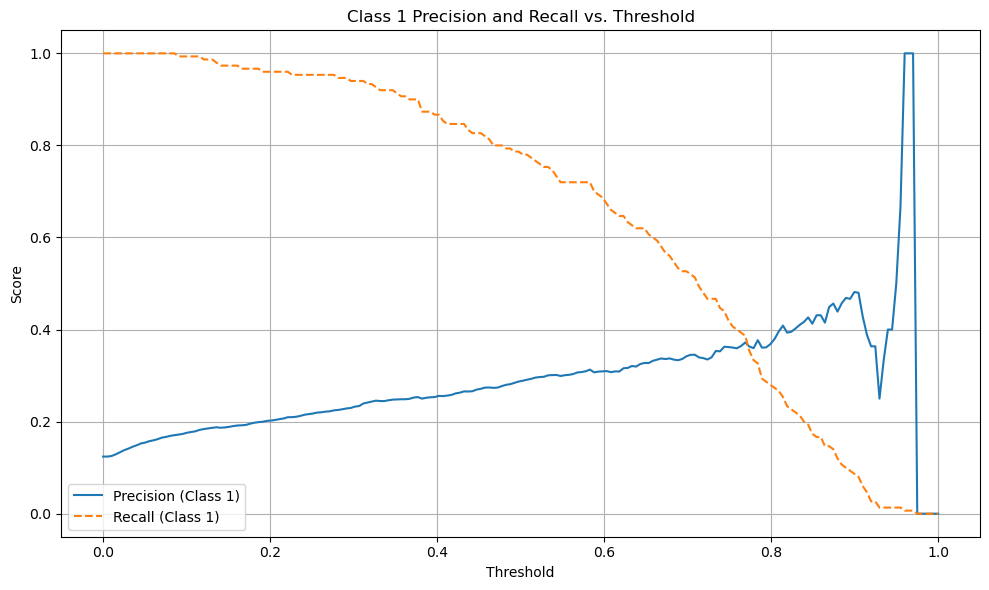

In [ ]:
# Fitting balanced model
log_model = LogisticRegression(class_weight='balanced', solver='liblinear', C=200, n_jobs=-1)
log_model.fit(X_train, y_train)

log_y_pred = log_model.predict(X_test)
log_y_proba = log_model.predict_proba(X_test)[:, 1]

# Classification Reports
print("Classification Report:\n", classification_report(y_test, log_y_pred))
print("Accuracy:", accuracy_score(y_test, log_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, log_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, log_y_proba))


# Plotting precision vs recall over different thresholds 
thresholds = np.linspace(0.0, 1.0, 200)
precisions = []
recalls = []

for t in thresholds:
    preds = (log_y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, preds, pos_label=1, zero_division=0))
    recalls.append(recall_score(y_test, preds, pos_label=1))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision (Class 1)')
plt.plot(thresholds, recalls, label='Recall (Class 1)', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Class 1 Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SVM

We train a Support Vector Classifier with an RBF kernel to detect nonlinear relationships between predictors and diabetes status (HbA1c ≥ 6.5%). The model aims to uncover complex interactions not handled by linear models.

Key Properties:
- Captures nonlinear boundaries in the input space, especially when using nonlinear `rbf` kernel
- Strong performance with minimal runtime
- `class_weight=balanced` to address massive imbalance between diabetic and non-diabetic cases.

### Performance Summary:

- **Accuracy:** 68.0%
- **ROC AUC:** 0.81
- **Recall (Class 1):** 0.86
- **Precision (Class 1):** 0.26
- **F1-Score (Class 1):** 0.40

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      1059
           1       0.26      0.86      0.40       150

    accuracy                           0.68      1209
   macro avg       0.62      0.76      0.59      1209
weighted avg       0.88      0.68      0.74      1209


Confusion Matrix:
[[695 364]
 [ 21 129]]
ROC AUC Score: 0.812612527541706


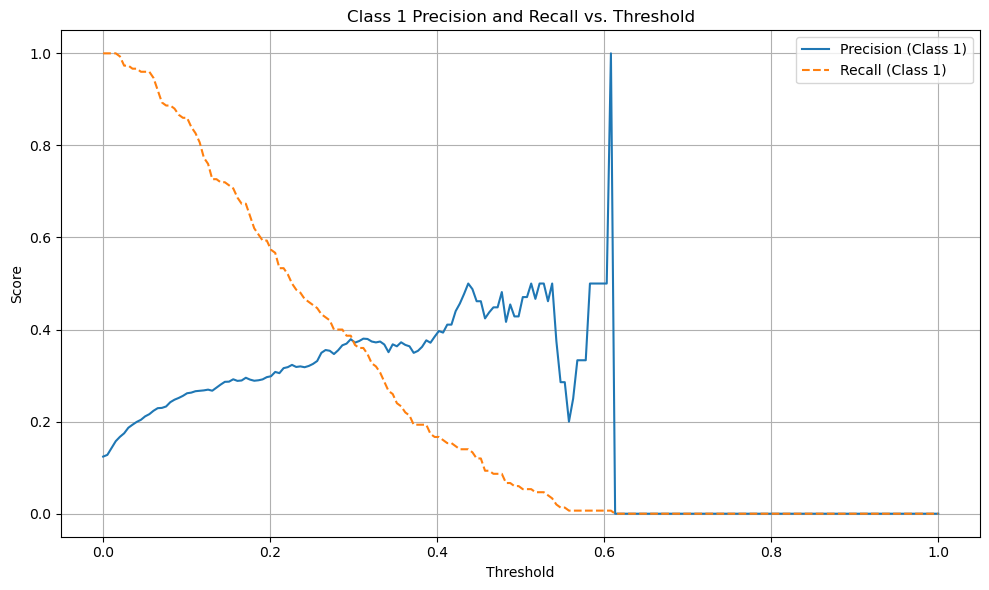

In [ ]:
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

svm_y_proba = svm_model.predict_proba(X_test)[:, 1]

threshold = 0.1

svm_y_pred = (svm_y_proba >= threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, svm_y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, svm_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, svm_y_proba))

# Plotting precision vs recall over different thresholds 
thresholds = np.linspace(0.0, 1.0, 200)
precisions = []
recalls = []

for t in thresholds:
    preds = (svm_y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, preds, pos_label=1, zero_division=0))
    recalls.append(recall_score(y_test, preds, pos_label=1))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision (Class 1)')
plt.plot(thresholds, recalls, label='Recall (Class 1)', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Class 1 Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## XGBoost

XGBoost is a high-performance gradient-boosted tree algorithm that can model complex, nonlinear feature interactions and variable importance in a robust way. We apply it to our binary classification task of diabetes risk.

Key Properties:
- Ensemble-based method capturing feature hierarchies and interactions
- Built-in handling of missing data and class imbalance
- Feature importance metrics for interpretability
- `scale_pos_weight` was scaled to help address class imbalances, as well as using aucpr as the evalution metric

### Performance Summary:

- **Accuracy:** 67.0%
- **ROC AUC:** 0.81
- **Recall (Class 1):** 0.80
- **Precision (Class 1):** 0.25
- **F1-Score (Class 1):** 0.38

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1059
           1       0.25      0.80      0.38       150

    accuracy                           0.67      1209
   macro avg       0.60      0.73      0.58      1209
weighted avg       0.87      0.67      0.73      1209


Confusion Matrix:
[[693 366]
 [ 30 120]]
ROC AUC Score: 0.812612527541706


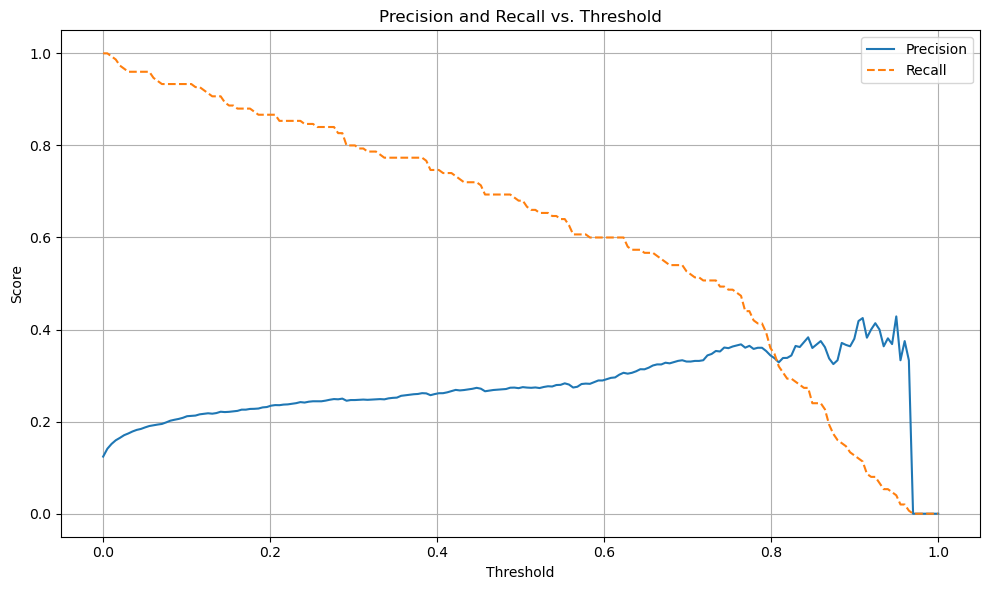

In [ ]:
class_counts = Counter(y_train)
scale_pos_weight = (class_counts[0] / class_counts[1]) * 3

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    booster='gbtree',
    eval_metric='aucpr',  
    scale_pos_weight=scale_pos_weight,
    max_depth=4, 
    learning_rate=0.05,  
    n_estimators=500,  
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
threshold = 0.3  
xgb_y_pred = (xgb_y_pred_proba >= threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, xgb_y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, xgb_y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, svm_y_proba))

thresholds = np.linspace(0.0, 1.0, 200)
precisions = []
recalls = []

for t in thresholds:
    preds = (xgb_y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance (XGBoost)

To interpret the XGBoost model, we examine feature importance values derived from the total gain across tree splits. The top contributors offer insights into which variables most strongly influence model decisions. In order to get accurate values from our one-hot encoded variables we group all one-hot encoded columns back to their base variable using regex. Importance values are **summed across all one-hot columns** belonging to the same categorical variable. This produces an overrall clearer view of **which underlying variables** (e.g., race, marital status, income) drive model behavior, without splitting importance for variables with many categories.


### Top Features (Relative):

| Rank | Feature        | Description                                | Importance |
|------|----------------|--------------------------------------------|------------|
| 1    | AGE_BMI        | Interaction between age and BMI            | 0.125      |
| 2    | RIDRETH1       | Race/Ethnicity (collapsed encoding)        | 0.105      |
| 3    | DMDMARTL       | Marital status                             | 0.102      |
| 4    | RIDAGEYR       | Age (in years)                             | 0.049      |
| 5    | BORN_CITZ      | Birthplace/Citizenship status              | 0.044      |

### Key Takeaways:

- **Biometric-Demographic Interactions Dominate**: Features like `AGE_BMI`, `SEX_INCOME`, and `AGE_INCOME` suggest that the **interplay between demographic and health variables is more predictive** than any single variable alone.
- **Race/Ethnicity Effects**: `RIDRETH1` and `RIDRETH3` collectively contribute over 13% to the model's decision-making, pointing to racial disparities in predicted diabetes risk—echoing known public health patterns.
- **Social Determinants Matter**: Marital status, education, household size, and birthplace are all influential, highlighting the **socioeconomic and lifestyle context** in shaping metabolic outcomes.
- **Anthropometric Indicators**: BMI-related features (e.g., waist circumference, leg length, waist-hip ratio) remain core to diabetes prediction.

These findings support our hypothesis that HbA1c levels and diabetes risk are shaped by **complex, interacting relationships** across biometric and demographic dimensions—justifying the use of nonlinear models and interaction terms.


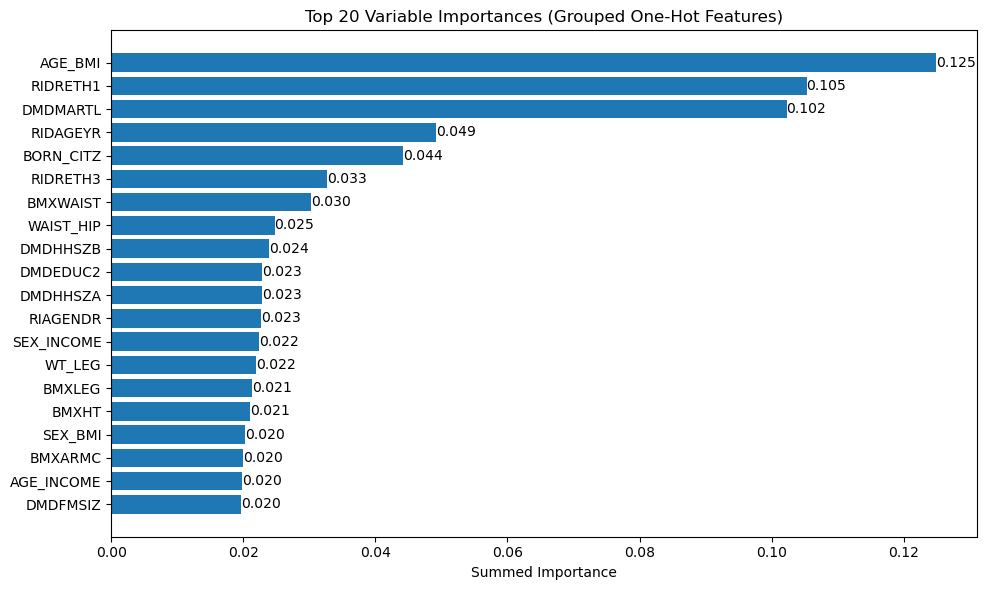

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re

importances = xgb_model.feature_importances_
feat_names = X_train.columns

var_importance = {}

for feature, importance in zip(feat_names, importances):
    # Try to match one-hot encoded features (e.g., RIDRETH1_1.0 → RIDRETH1)
    base_var = re.split(r'_\d+\.?\d*$', feature)[0]
    var_importance[base_var] = var_importance.get(base_var, 0) + importance

var_df = pd.DataFrame({
    'Variable': list(var_importance.keys()),
    'Importance': list(var_importance.values())
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(var_df['Variable'], var_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Variable Importances (Grouped One-Hot Features)")
plt.xlabel("Summed Importance")
plt.bar_label(bars, fmt='%.3f')
plt.tight_layout()
plt.show()


## Summary

This project aimed to examine how biometric, demographic, and socioeconomic features may influence Hemoglobin A1c (HbA1c) levels. Using a sample of information from the 2017–2018 NHANES dataset.

### Modeling Insights

All models faced significant challenges in **balancing recall and precision**, especially on the minority (diabetic) class. In earlier experiments, our models simply defaulted to predicting all individuals as non-diabetic due to extreme class imbalance. Even with class weighting and oversampling methods like **SMOTE**, improvements were only marginal.

Ultimately, all three models converged to similar performance:
- **Logistic Regression** offered the cleanest interpretation, achieving 79% recall but only 29% precision on the minority class.
- **SVM** achieved the highest recall (86%) but also the lowest precision (26%), severely over-flagging risk.
- **XGBoost** struck a comparable balance with 80% recall and similar overall metrics, while offering insight through feature importance.

Despite different algorithmic mechanisms, the models performed nearly identically, suggesting that **differences in results stemmed more from parameter tuning than from model type**. This convergence reflects two limitations in the dataset:

1. **Class imbalance** made minority-class learning unstable.
2. **Feature informativeness was limited** — XGBoost’s feature importance scores revealed that the vast majority of predictors had very little influence on model decisions. A small handful of features (e.g., `AGE_BMI`, `RIDRETH1`, `DMDMARTL`) dominated, while most contributed negligible signal.

This indicates that **many of the NHANES variables we selected may carry little to no predictive value for diabetes status**, at least in our limited modeling. Our interaction features helped, but they couldn't fully overcome the sparsity of predictive signals.

### Final Thoughts

These findings highlight the **need for richer data** when modeling diabetes risk at the population level, sparse factors like the ones naively selected for this project are not sufficient, for accurate models.

### Next Steps

Given the challenges that we observed, there are a host of avenues for future work.

- **Refining Feature Selection**: Focus on collecting or engineering more meaningful variables particularly lifestyle data, ethnic indicators, or clinical measurements.
  
- **Expand Interaction Features**: Work on experimenting with a larger host of interaction terms, informed by clinical research and domain knowledge, to better capture non-additive effects.

- **Improve Missing Data Handling**:
  - Explore **alternative imputation techniques**, such as KNN, multivariate imputation, or MICE imputation tailored to feature types.
  - Test **alternative culling criteria**, such as conditional missingness or feature-specific thresholds, rather than uniform NA cutoffs.

- **Feature Engineering Audits**: Revisit one-hot encoding strategies and consider some form of dimensionality reduction or target-guided encoding for categorical variables with high number of values.